In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
from utils import get_getter
from universal_divergence import estimate
from utils import nn_l2_mean


slim = tf.contrib.slim
ds = tf.contrib.distributions
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Populating the interactive namespace from numpy and matplotlib


In [2]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)


### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [3]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6, getter=None, reuse=False):
    with tf.variable_scope("generator", custom_getter=getter, reuse=reuse):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [4]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [5]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=20000,
    viz_every=2000,
    z_dim=256,
    x_dim=2,
    ema_enabled=True,
)

## Construct model and training ops

In [6]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

g_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)

ema = tf.train.ExponentialMovingAverage(decay=0.999)
maintain_averages_op = ema.apply(gen_vars)
with tf.control_dependencies([g_train_op]):
    g_train_op = tf.group(maintain_averages_op)
samples_ema = generator(noise, output_dim=params['x_dim'], getter=get_getter(ema),reuse=True)

if params['ema_enabled']:
    print('ema enabled')
    run_samples = samples_ema
else:
    print('ema disabled')
    run_samples = samples

ema enabled


## Train

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/20001 [00:00<?, ?it/s]

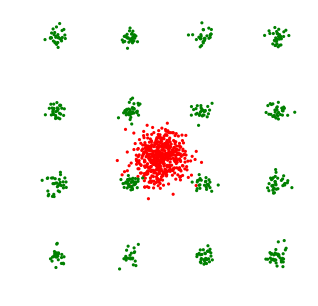

 10%|▉         | 2000/20001 [01:17<03:57, 75.78it/s]  

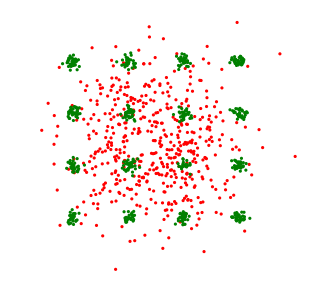

 20%|█▉        | 4000/20001 [02:32<03:39, 72.97it/s]  

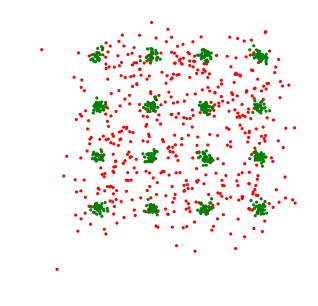

 30%|██▉       | 6000/20001 [03:39<02:40, 87.13it/s]

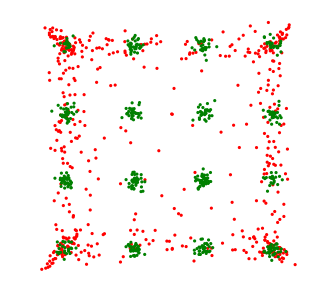

 40%|███▉      | 7995/20001 [04:47<02:14, 89.03it/s]

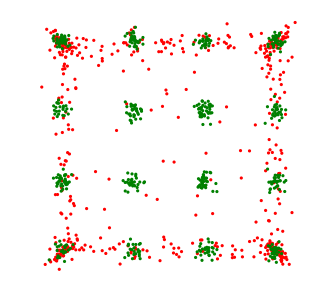

 50%|████▉     | 10000/20001 [05:54<01:54, 87.54it/s]

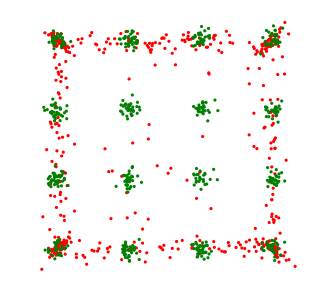

 60%|█████▉    | 12000/20001 [07:06<01:47, 74.66it/s]

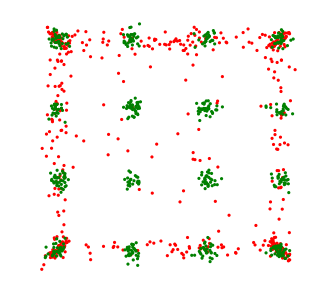

 70%|██████▉   | 14000/20001 [08:19<01:21, 73.87it/s]

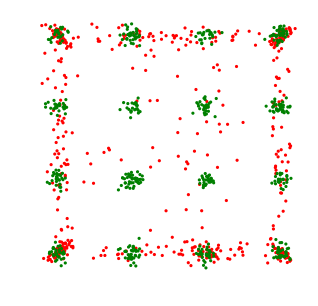

 80%|███████▉  | 15995/20001 [09:33<00:56, 71.30it/s]

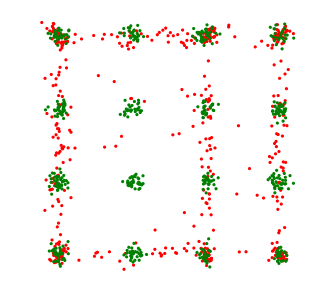

 90%|████████▉ | 17997/20001 [10:46<00:27, 73.09it/s]

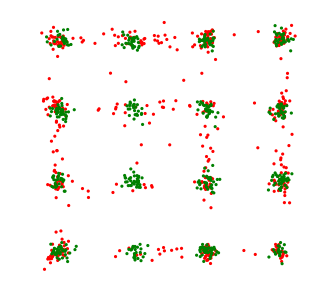

100%|█████████▉| 19999/20001 [12:01<00:00, 72.79it/s]

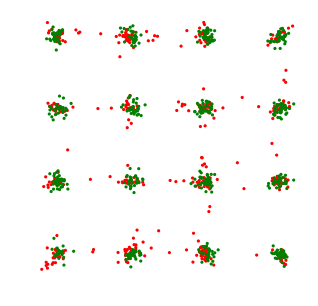

100%|██████████| 20001/20001 [12:06<00:00, 27.53it/s]


In [8]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']

nn_every = 200
y_ref = sess.run( data)
nn_dist = []
nn_kl =[]
for i in tqdm(range(params['max_iter']+1)):
    f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    fs.append(f)
    if (i) % viz_every == 0:
        np_samples.append(np.vstack([sess.run(run_samples) for _ in range(n_batches_viz)]))

        xx, yy = sess.run([run_samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], c='r', edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
        axis('off')
        show()
        
    if (i) % nn_every == 0:
        x = np.vstack([sess.run(run_samples) for _ in range(n_batches_viz)])
        l2nn = nn_l2_mean(x,y_ref)
        kl =estimate(x, y_ref,k=1)
        nn_dist.append(l2nn)
        nn_kl.append(kl)

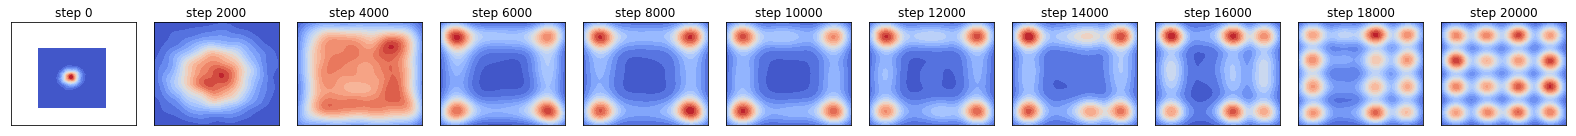

In [9]:
np_samples_ = np_samples[::1]
cols = len(np_samples_)

figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm',bw=0.40, n_levels=20, clip=[[-6,6]]*2)
#     ax2.set(xlim=(None, 6), aspect="equal")
#     ax2.collections[0].set_alpha(0)
    xticks([]); yticks([])
    title('step %d'%(i*viz_every))
    
gcf().tight_layout()

In [10]:
np.save('kl_rms_ema_enabled{}.npy'.format(params['ema_enabled']),nn_kl)
np.save('nn_rms_ema_enabled{}.npy'.format(params['ema_enabled']),nn_dist)

In [11]:
ls *.npy

kl_rms_ema_enabledFalse.npy  nn_rms_ema_enabledFalse.npy  plot_con_kl.npy
kl_rms_ema_enabledTrue.npy   nn_rms_ema_enabledTrue.npy   plot_con_nn.npy


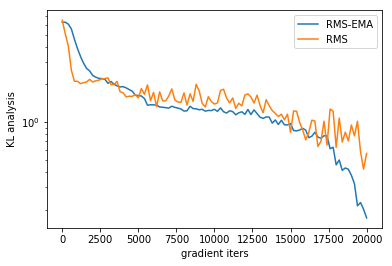

In [12]:
x=np.load('kl_rms_ema_enabledTrue.npy')
y=np.load('kl_rms_ema_enabledFalse.npy')
t=np.linspace(0,20000,len(x))
plt.semilogy(t,x)
plt.semilogy(t,y)

plt.xlabel('gradient iters')
plt.ylabel('KL analysis')
plt.legend(['RMS-EMA','RMS'])

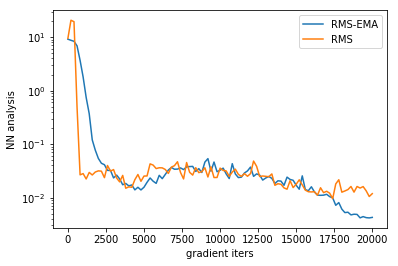

In [13]:
x=np.load('nn_rms_ema_enabledTrue.npy')
y=np.load('nn_rms_ema_enabledFalse.npy')
t=np.linspace(0,20000,len(x))
plt.semilogy(t,x)
plt.semilogy(t,y)

plt.xlabel('gradient iters')
plt.ylabel('NN analysis')
plt.legend(['RMS-EMA','RMS'])